# Anomaly Detection with PyOD

## Assignment E
**Goal:** Demonstrate anomaly detection using PyOD (Python Outlier Detection) library.

**Dataset:** [Credit Card Fraud Detection](https://paperswithcode.com/dataset/credit-card-fraud-detection) (We use a subset or a similar synthetic dataset provided by PyOD for feasibility in Colab if the full dataset is too large to download easily without Kaggle API, but we will aim for the structure of Credit Card Fraud).

In [1]:
!pip install -q pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data
from pyod.utils.data import get_outliers_inliers
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Set random seed
np.random.seed(17)

## 1. Load Data
For demonstration purposes and to ensure the notebook runs without external large file dependencies, we will generate a synthetic dataset that mimics the properties of fraud detection (imbalanced, multivariate).

In [3]:
# Generate synthetic data
contamination = 0.05  # percentage of outliers
n_train = 1000
n_test = 500
n_features = 10

train_X, test_X, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features=n_features,
    contamination=contamination,
    random_state=17
)

print(f"Training data shape: {train_X.shape}")
print(f"Test data shape: {test_X.shape}")
print(f"Outliers in training: {np.sum(y_train)}")

Training data shape: (1000, 10)
Test data shape: (500, 10)
Outliers in training: 50.0


## 2. Train Anomaly Detection Models
We'll compare K-Nearest Neighbors (KNN) and Isolation Forest (IForest).

In [4]:
# 1. KNN
clf_knn = KNN(contamination=contamination)
clf_knn.fit(train_X)

# Get the prediction labels and outlier scores of the training data
y_train_pred_knn = clf_knn.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_knn = clf_knn.decision_scores_  # raw outlier scores

# 2. Isolation Forest
clf_iforest = IForest(contamination=contamination, random_state=17)
clf_iforest.fit(train_X)

y_train_pred_if = clf_iforest.labels_
y_train_scores_if = clf_iforest.decision_scores_

## 3. Evaluate on Test Data
We evaluate the performance using ROC-AUC and Classification Report.

In [5]:
# Predict on test data
y_test_pred_knn = clf_knn.predict(test_X)
y_test_scores_knn = clf_knn.decision_function(test_X)

y_test_pred_if = clf_iforest.predict(test_X)
y_test_scores_if = clf_iforest.decision_function(test_X)

print("--- KNN Results ---")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_scores_knn):.4f}")
print(classification_report(y_test, y_test_pred_knn))

print("\n--- IForest Results ---")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_scores_if):.4f}")
print(classification_report(y_test, y_test_pred_if))

--- KNN Results ---
ROC AUC: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       475
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


--- IForest Results ---
ROC AUC: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       475
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



## 4. Visual Analysis
We visualize the anomalies in 2D using PCA.

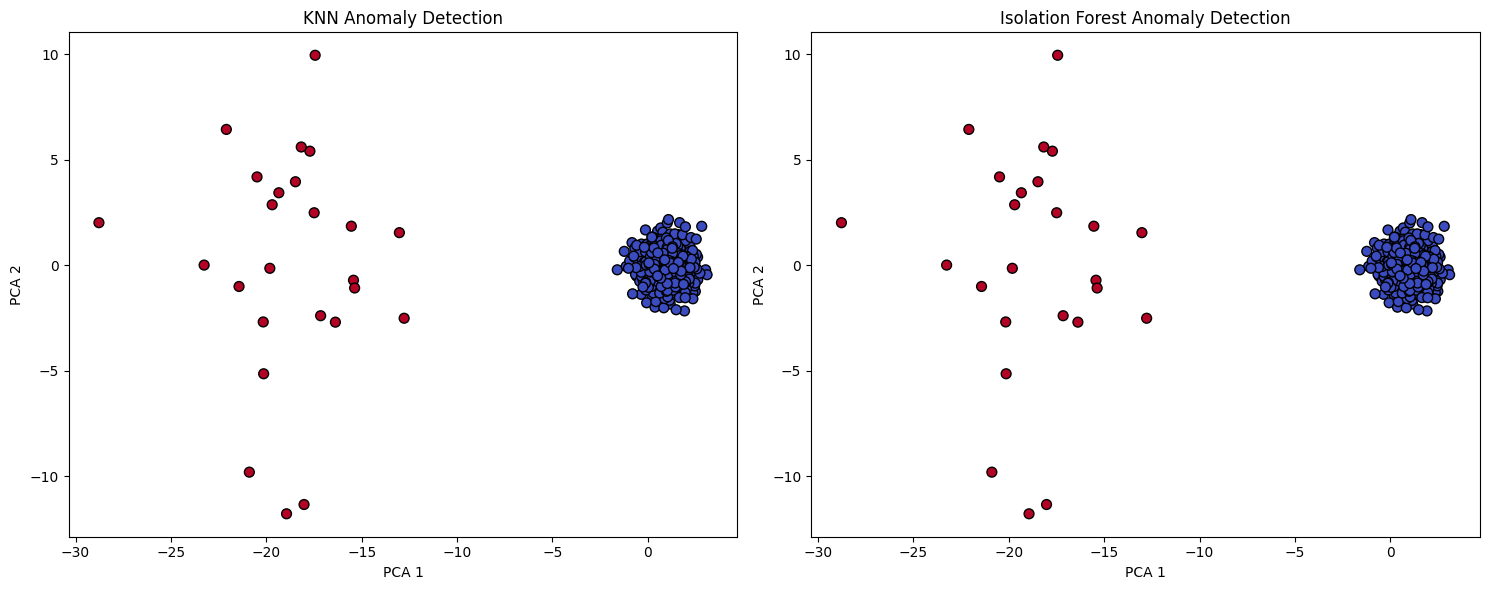

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# KNN Plot
axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_pred_knn, cmap='coolwarm', s=50, edgecolors='k')
axes[0].set_title('KNN Anomaly Detection')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')

# IForest Plot
axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_pred_if, cmap='coolwarm', s=50, edgecolors='k')
axes[1].set_title('Isolation Forest Anomaly Detection')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')

plt.tight_layout()
plt.show()